## Define Dependencies


In [ ]:
!pip install --upgrade torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install -q -U datasets
!pip install fsspec==2024.10.0
!pip install -q -U git+https://github.com/huggingface/transformers
!pip install --upgrade transformers
!pip install --upgrade bitsandbytes
!pip install --upgrade accelerate
!pip install datasets

Looking in indexes: https://download.pytorch.org/whl/cu121
INFO: pip is looking at multiple versions of torch to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.5/780.5 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 85.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 47.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 84.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 45.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.6 MB/s e

In [ ]:
!rm -f *.csv

In [ ]:
import os
import random
import functools
import csv
import re
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

from transformers import (
    AutoModelForCausalLM,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
)

from sklearn.metrics import f1_score, confusion_matrix, classification_report, balanced_accuracy_score, accuracy_score,precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from google.colab import files
from google.colab import userdata
from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model
from datasets import Dataset, DatasetDict



## Environment setup

In [ ]:
# Environment setup
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TOKENIZERS_PARALLELISM"] = "false"
warnings.filterwarnings("ignore")

In [ ]:
def set_all_seeds(seed):
       """Set all seeds for reproducibility"""

       random.seed(seed)
       np.random.seed(seed)
       torch.manual_seed(seed)
       if torch.cuda.is_available():
           torch.cuda.manual_seed(seed)
           torch.cuda.manual_seed_all(seed)
       torch.backends.cudnn.deterministic = True
       torch.backends.cudnn.benchmark = False

In [ ]:
set_all_seeds(49)

In [ ]:
my_secret_key= userdata.get('HF_TOKEN')

In [ ]:
model_name = "google/gemma-2-9b-it"


In [ ]:
my_secret_key= userdata.get('HF_TOKEN')

## Define Model

In [ ]:
quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True
)

In [ ]:
# text generative model
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    quantization_config=quant_config,
    torch_dtype=torch.float16,
    num_labels=3,

)

model.config.use_cache = False

tokenizer = AutoTokenizer.from_pretrained(model_name, token=my_secret_key)
if tokenizer.pad_token is None:
  tokenizer.pad_token_id = tokenizer.eos_token_id
  tokenizer.pad_token = tokenizer.eos_token

config.json:   0%|          | 0.00/857 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/39.1k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.90G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/3.67G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/47.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

In [ ]:
print(f"\nCUDA available: {torch.cuda.is_available()}")



CUDA available: True


## Load Dataset

In [ ]:
def upload_files():
    """
    Upload multiple dataset files with organized handling
    Returns: Dictionary containing uploaded files organized by dataset
    """
    uploaded_files = {}
    dataset_names = ['D1', 'D2', 'D3','D4','D5']
    file_types = ['train', 'val', 'test']

    for dataset in dataset_names:
        print(f"\nPlease upload files for {dataset} dataset:")
        dataset_files = {}

        for file_type in file_types:
            print(f"Upload {dataset}_{file_type}.csv:")
            try:
                uploaded = files.upload()
                expected_filename = f"{dataset}_{file_type}.csv"

                if expected_filename in uploaded:
                    dataset_files[file_type] = expected_filename
                    print(f"✓ Successfully uploaded {expected_filename}")
                else:
                    print(f"⚠️ Warning: {expected_filename} not found in uploaded files")
                    continue

            except Exception as e:
                print(f"Error uploading {dataset}_{file_type}.csv: {e}")
                continue

        if len(dataset_files) == 3:
            uploaded_files[dataset] = dataset_files
        else:
            print(f"⚠️ Incomplete files for {dataset}, skipping this dataset")

        print(f"\nCompleted uploads for {dataset}")

        if dataset != dataset_names[-1]:
            continue_upload = input(f"\nDo you want to upload files for {dataset_names[dataset_names.index(dataset) + 1]}? (yes/no): ")
            if continue_upload.lower() not in ['y', 'yes']:
                print("Stopping upload process.")
                break

    # Summary of uploads
    print("\nUpload Summary:")
    for dataset, files_dict in uploaded_files.items():
        print(f"\n{dataset} Dataset:")
        for file_type, filename in files_dict.items():
            print(f"  - {file_type}: {filename}")

    return uploaded_files

In [ ]:
def load_datasets(uploaded_files):
    """
    Load datasets from uploaded files
    Args:
        uploaded_files: Dictionary returned from upload_files()
    Returns:
        Dictionary of DataFrames for each dataset
    """
    datasets = {}

    for dataset_name, files in uploaded_files.items():
        try:
            train = pd.read_csv(files['train'])
            val = pd.read_csv(files['val'])
            test = pd.read_csv(files['test'])

            datasets[dataset_name] = {
                'train': train,
                'val': val,
                'test': test
            }
            print(f"✓ Successfully loaded {dataset_name} dataset")

            print(f"  Train: {train.shape[0]} rows")
            print(f"  Val: {val.shape[0]} rows")
            print(f"  Test: {test.shape[0]} rows")

        except Exception as e:
            print(f" Error loading {dataset_name} dataset: {e}")

    return datasets

In [ ]:


# Upload and load datasets
print("Starting dataset upload process...")
uploaded_files = upload_files()

if not uploaded_files:
        print("No datasets were successfully uploaded. Exiting.")

datasets = load_datasets(uploaded_files)
if not datasets:
        print("No datasets were successfully loaded. Exiting.")


Starting dataset upload process...

Please upload files for D1 dataset:
Upload D1_train.csv:


Saving D1_train.csv to D1_train.csv
✓ Successfully uploaded D1_train.csv
Upload D1_val.csv:


Saving D1_val.csv to D1_val.csv
✓ Successfully uploaded D1_val.csv
Upload D1_test.csv:


Saving D1_test.csv to D1_test.csv
✓ Successfully uploaded D1_test.csv

Completed uploads for D1

Do you want to upload files for D2? (yes/no): yes

Please upload files for D2 dataset:
Upload D2_train.csv:


Saving D2_train.csv to D2_train.csv
✓ Successfully uploaded D2_train.csv
Upload D2_val.csv:


Saving D2_val.csv to D2_val.csv
✓ Successfully uploaded D2_val.csv
Upload D2_test.csv:


Saving D2_test.csv to D2_test.csv
✓ Successfully uploaded D2_test.csv

Completed uploads for D2

Do you want to upload files for D3? (yes/no): yes

Please upload files for D3 dataset:
Upload D3_train.csv:


Saving D3_train.csv to D3_train.csv
✓ Successfully uploaded D3_train.csv
Upload D3_val.csv:


Saving D3_val.csv to D3_val.csv
✓ Successfully uploaded D3_val.csv
Upload D3_test.csv:


Saving D3_test.csv to D3_test.csv
✓ Successfully uploaded D3_test.csv

Completed uploads for D3

Do you want to upload files for D4? (yes/no): yes

Please upload files for D4 dataset:
Upload D4_train.csv:


Saving D4_train.csv to D4_train.csv
✓ Successfully uploaded D4_train.csv
Upload D4_val.csv:


Saving D4_val.csv to D4_val.csv
✓ Successfully uploaded D4_val.csv
Upload D4_test.csv:


Saving D4_test.csv to D4_test.csv
✓ Successfully uploaded D4_test.csv

Completed uploads for D4

Do you want to upload files for D5? (yes/no): yes

Please upload files for D5 dataset:
Upload D5_train.csv:


Saving D5_train.csv to D5_train.csv
✓ Successfully uploaded D5_train.csv
Upload D5_val.csv:


Saving D5_val.csv to D5_val.csv
✓ Successfully uploaded D5_val.csv
Upload D5_test.csv:


Saving D5_test.csv to D5_test.csv
✓ Successfully uploaded D5_test.csv

Completed uploads for D5

Upload Summary:

D1 Dataset:
  - train: D1_train.csv
  - val: D1_val.csv
  - test: D1_test.csv

D2 Dataset:
  - train: D2_train.csv
  - val: D2_val.csv
  - test: D2_test.csv

D3 Dataset:
  - train: D3_train.csv
  - val: D3_val.csv
  - test: D3_test.csv

D4 Dataset:
  - train: D4_train.csv
  - val: D4_val.csv
  - test: D4_test.csv

D5 Dataset:
  - train: D5_train.csv
  - val: D5_val.csv
  - test: D5_test.csv
✓ Successfully loaded D1 dataset
  Train: 1599 rows
  Val: 200 rows
  Test: 200 rows
✓ Successfully loaded D2 dataset
  Train: 7200 rows
  Val: 800 rows
  Test: 2000 rows
✓ Successfully loaded D3 dataset
  Train: 9795 rows
  Val: 1224 rows
  Test: 1225 rows
✓ Successfully loaded D4 dataset
  Train: 4263 rows
  Val: 533 rows
  Test: 533 rows
✓ Successfully loaded D5 dataset
  Train: 11999 rows
  Val: 1501 rows
  Test: 1500 rows


In [ ]:
for dataset_name, dataset_files in datasets.items():
    globals()[dataset_name] = dataset_files

In [ ]:
def analyze_dataset(D, dataset_name):
    """
    Analyzes the dataset by checking for NULL values and displaying label distributions.

    Args:
        D (dict): A dictionary containing train, validation, and test datasets as Pandas DataFrames.
        dataset_name (str): Name of the dataset for display purposes.

    Returns:
        None
    """
    for split in ['train', 'val', 'test']:
        if split in D:
            print(f"NULL values in {dataset_name} {split} dataframe:")
            print(D[split].isnull().sum())

            print(f"\nLabel distribution for {dataset_name} {split}:")
            if 'label' in D[split].columns:
                print(D[split]['label'].value_counts())
            else:
                print("No 'label' column found in this dataset.")

            print(f"\nDataset shape: {D[split].shape}")

            print("-" * 50)

In [ ]:
analyze_dataset(D1,'D1')
analyze_dataset(D2,'D2')
analyze_dataset(D3,'D3')
analyze_dataset(D4,'D4')
analyze_dataset(D5,'D5')

NULL values in D1 train dataframe:
text     0
label    0
dtype: int64

Label distribution for D1 train:
label
0    794
1    414
2    391
Name: count, dtype: int64

Dataset shape: (1599, 2)
--------------------------------------------------
NULL values in D1 val dataframe:
text     0
label    0
dtype: int64

Label distribution for D1 val:
label
0    99
1    52
2    49
Name: count, dtype: int64

Dataset shape: (200, 2)
--------------------------------------------------
NULL values in D1 test dataframe:
text     0
label    0
dtype: int64

Label distribution for D1 test:
label
0    99
1    52
2    49
Name: count, dtype: int64

Dataset shape: (200, 2)
--------------------------------------------------
NULL values in D2 train dataframe:
text     0
label    0
dtype: int64

Label distribution for D2 train:
label
0    3369
1    2187
2    1644
Name: count, dtype: int64

Dataset shape: (7200, 2)
--------------------------------------------------
NULL values in D2 val dataframe:
text     0
label  

In [ ]:
#combaining all the train dataset  together to a single training dataset to do the training
train_data=pd.concat([D1['train'], D2['train'], D3['train'], D4['train'], D5['train']], ignore_index=True)
val_data=pd.concat([D1['val'], D2['val'], D3['val'], D4['val'], D5['val']], ignore_index=True)

In [ ]:
# Function to preprocess text data
def preprocess_text(text):
    import re

    text = re.sub(r'http\S+|www.\S+', '', text)


    text = re.sub(r'@\w+', '', text)

    text = re.sub(r'[^\w\s.,!?;:\'\"()-]', '', text)

    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [ ]:
train_data['text']=train_data['text'].apply(preprocess_text)
val_data['text']=val_data['text'].apply(preprocess_text)

In [ ]:
D1['test']['text'] = D1['test']['text'].apply(preprocess_text)
D2['test']['text'] = D2['test']['text'].apply(preprocess_text)
D3['test']['text'] = D3['test']['text'].apply(preprocess_text)
D4['test']['text'] = D4['test']['text'].apply(preprocess_text)
D5['test']['text'] = D5['test']['text'].apply(preprocess_text)

In [ ]:
class_weights=(1/train_data.label.value_counts(normalize=True).sort_index()).tolist()
class_weights=torch.tensor(class_weights)
class_weights=class_weights/class_weights.sum()

print(f"class weights:{class_weights}")

dataset_train = Dataset.from_pandas(train_data)
dataset_val = Dataset.from_pandas(val_data)


dataset_train_shuffled = dataset_train.shuffle(seed=43)

dataset = DatasetDict({
    'train': dataset_train_shuffled,
    'val': dataset_val
    })

class weights:tensor([0.2038, 0.3266, 0.4696])


In [ ]:
# Using .shape to get the number of rows and columns
print(f"Number of rows in train data: {train_data.shape[0]}")

Number of rows in train data: 34856


##Prompt

In [ ]:
def generate_prompt_unified(text, examples):
  """
    Unified prompt generator that handles both zero-shot and few-shot cases

    Args:
        text (str): The text to be classified
        examples (list, optional): List of tuples containing (example_text, classification)
                                 If None, generates zero-shot prompt
                                 If provided, generates few-shot prompt
    """
  base_prompt = """You are a strict text classifier. Your task is to classify the given text into one of three categories:

  CLASSIFICATION CRITERIA:
  0: Not aggressive - Direct, neutral, or positive statements
  1: Covertly Aggressive - Contains sarcasm, "air quotes", passive-aggression, or subtle criticism
  2: Overtly Aggressive - Direct confrontation, insults, or hostile language - Clear anger/hatred

  **Instructions:**
  - **DO NOT** provide any explanation.
  - **DO NOT** add extra text or notes.
  - **DO NOT** rephrase the label.
  - **ONLY** return one of these exact labels either 0, 1, or 2 as classification:
  - **NOTE** that covertly(1) and overtly aggressive(2) content may be less common but equally important to detect."""
  if examples is not None:
        examples_section = "\n\nExamples:\n\n"
        for example_text, classification in examples:
            examples_section += f'"{example_text}" → {classification}\n'
        examples_section += "\n"
  else:
        # Zero-shot case - no examples
        examples_section = "\n\n"

    # Final prompt assembly
  final_prompt = f"""{base_prompt}{examples_section}Text: {text}

Classification:"""

  return final_prompt


## Testing

In [ ]:
def predict(texts, model, tokenizer, prompt_generator,examples, batch_size=8):
    """
    Make predictions on a batch of texts using the specified model

    Args:
        texts: List of texts to classify
        model: The language model
        tokenizer: The tokenizer
        prompt_generator: Function to generate prompts (zero-shot or few-shot)
        examples: List of example tuples for few-shot (optional)
        batch_size: Batch size for processing
    """
    predictions = []

    for i in tqdm(range(0, len(texts), batch_size)):
        batch_texts = texts[i:i + batch_size]
        batch_predictions = []

        for text in batch_texts:

            prompt = prompt_generator(text, examples)

            inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512)
            inputs = inputs.to(model.device)

            with torch.no_grad():
                outputs = model.generate(
                    **inputs,
                    max_new_tokens=5,
                    num_return_sequences=1,
                    temperature=0.1,
                    top_p=0.95,
                    do_sample=True,
                    pad_token_id=tokenizer.eos_token_id
                )

            generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
            matches = re.findall(r'\d+', generated_text)
            if matches and int(matches[-1]) in [0, 1, 2]:
                prediction = int(matches[-1])
            else:
                prediction = 0

            batch_predictions.append(prediction)

        predictions.extend(batch_predictions)

    return np.array(predictions)

In [ ]:
def evaluate_dataset(y_true, y_pred, dataset_name):
    """Evaluate model performance for a specific dataset"""
    print(f"\nResults for {dataset_name}:")

    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy:.3f}')

    target_names = ['Not Aggressive', 'Covertly Aggressive', 'Overtly Aggressive']

    # Use numeric labels in classification_report
    report = classification_report(
        y_true,
        y_pred,
        labels=[0, 1, 2],
        target_names=target_names
    )
    print('\nClassification Report:')
    print(report)

    # Use numeric labels for confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred, labels=[0, 1, 2])

    # Then plot with string labels
    fig, ax = plt.subplots(figsize=(7, 5))
    sns.heatmap(conf_matrix, annot=True, cmap="Greens", fmt="d", ax=ax,
                xticklabels=target_names, yticklabels=target_names)
    ax.set_ylabel('true value')
    ax.set_xlabel('predicted value')
    plt.title('Confusion Matrix')
    plt.show()

    return {
        'accuracy': accuracy,
        'classification_report': report,
        'confusion_matrix': conf_matrix
    }

In [ ]:
print(f"\nCUDA available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    current_device = torch.cuda.current_device()
    print(f"Current CUDA device ID: {current_device}")
    print(f"Current CUDA device name: {torch.cuda.get_device_name(current_device)}")

    device = next(model.parameters()).device
    print(f"Model is on device: {device}")

    if isinstance(model, torch.nn.DataParallel):
        print(f"DataParallel is using devices: {model.device_ids}")
else:
    print("CUDA is not available")


CUDA available: True
Current CUDA device ID: 0
Current CUDA device name: NVIDIA A100-SXM4-40GB
Model is on device: cuda:0


In [ ]:
def process_single_dataset(data, model, tokenizer, dataset_name, prompt,examples=None):
    """
    Process a single dataset and return results without applying class weights.

    Args:
        data: Dictionary containing train, val, test datasets
        model: The language model to use for predictions
        tokenizer: The tokenizer for the model
        dataset_name: Name of the dataset for reporting
        prompt: Function to generate prompts from text

    Returns:
        Tuple of (results_dataframe, evaluation_results)
    """
    print(f"\nProcessing {dataset_name}...")

    x_test = data['test']['text'].values
    y_test = data['test']['label'].values

    test_predictions = predict(x_test, model, tokenizer, prompt,examples=examples)

    results_df = pd.DataFrame({
        'text': x_test,
        'true_label': y_test,
        'predicted_label': test_predictions
    })

    evaluation_results = evaluate_dataset(y_test, test_predictions, dataset_name)

    results_df.to_csv(f'classification_results_{dataset_name}.csv', index=False)


Processing D1...


100%|██████████| 25/25 [02:11<00:00,  5.26s/it]



Results for D1:
Accuracy: 0.555

Classification Report:
                     precision    recall  f1-score   support

     Not Aggressive       0.94      0.52      0.67        99
Covertly Aggressive       0.35      0.67      0.46        52
 Overtly Aggressive       0.54      0.51      0.53        49

           accuracy                           0.56       200
          macro avg       0.61      0.57      0.55       200
       weighted avg       0.69      0.56      0.58       200



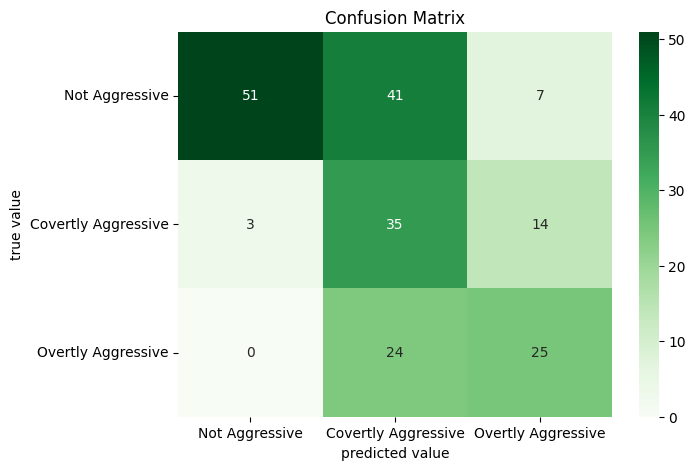

In [ ]:
model_copy=model
process_single_dataset(D1, model_copy, tokenizer, 'D1',generate_prompt_unified)


Processing D1...


100%|██████████| 25/25 [02:10<00:00,  5.21s/it]


Results for D1:
Accuracy: 0.650

Classification Report:
                     precision    recall  f1-score   support

     Not Aggressive       0.93      0.67      0.78        99
Covertly Aggressive       0.43      0.56      0.49        52
 Overtly Aggressive       0.56      0.71      0.63        49

           accuracy                           0.65       200
          macro avg       0.64      0.65      0.63       200
       weighted avg       0.71      0.65      0.67       200



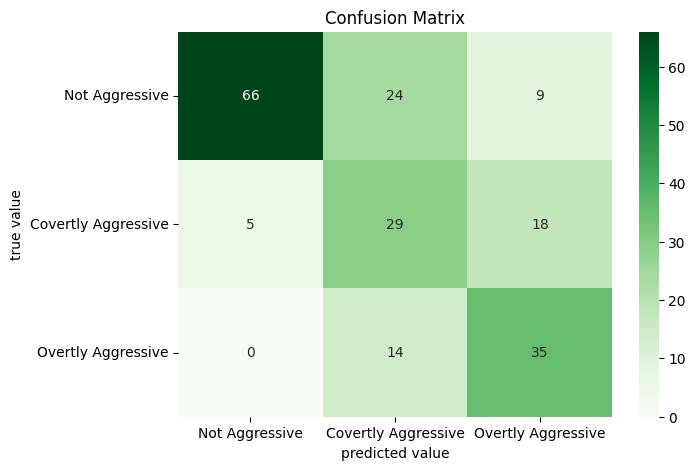

In [ ]:
model_copy=model
sample_examples_D1 = [
        ("The report is ready for review.", 0),
        ("Please let me know when you're available.", 0),
        ("I appreciate your quick response.", 0),
        ("Well, 'how convenient' for you — that's certainly one way to go about it.", 1),
        ("Some people never learn", 1),
        ("Interesting… I guess that's your way of handling things these days.", 1),
        ("You're completely wrong about this .", 2),
        ("Stop being so stubborn!", 2),
        ("You're an absolute idiot.", 2)
    ]

process_single_dataset(D1, model, tokenizer, 'D1',generate_prompt_unified,sample_examples_D1)


Processing D2...


100%|██████████| 250/250 [21:48<00:00,  5.23s/it]


Results for D2:
Accuracy: 0.451

Classification Report:
                     precision    recall  f1-score   support

     Not Aggressive       0.88      0.28      0.42       936
Covertly Aggressive       0.34      0.49      0.40       607
 Overtly Aggressive       0.42      0.75      0.54       457

           accuracy                           0.45      2000
          macro avg       0.55      0.51      0.45      2000
       weighted avg       0.61      0.45      0.44      2000



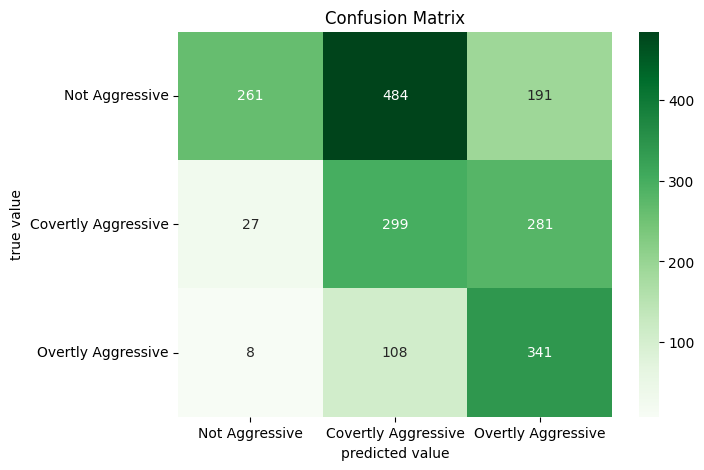

In [ ]:
model_copy=model
process_single_dataset(D2,model_copy, tokenizer, 'D2',generate_prompt_unified)

In [ ]:

few_shot_examples_D2= [
        ("The report is ready for review.", 0),
        ("Please let me know when you're available.", 0),
        ("I appreciate your quick response.", 0),
        ("Well, 'how convenient' for you — that's certainly one way to go about it.", 1),
        ("Some people never learn", 1),
        ("Interesting… I guess that's your way of handling things these days.", 1),
        ("You're completely wrong about this .", 2),
        ("Stop being so stubborn!", 2),
        ("You're an absolute idiot.", 2)
    ]


Processing D2...


100%|██████████| 250/250 [21:41<00:00,  5.21s/it]


Results for D2:
Accuracy: 0.473

Classification Report:
                     precision    recall  f1-score   support

     Not Aggressive       0.86      0.40      0.54       936
Covertly Aggressive       0.35      0.35      0.35       607
 Overtly Aggressive       0.38      0.80      0.52       457

           accuracy                           0.47      2000
          macro avg       0.53      0.51      0.47      2000
       weighted avg       0.59      0.47      0.48      2000



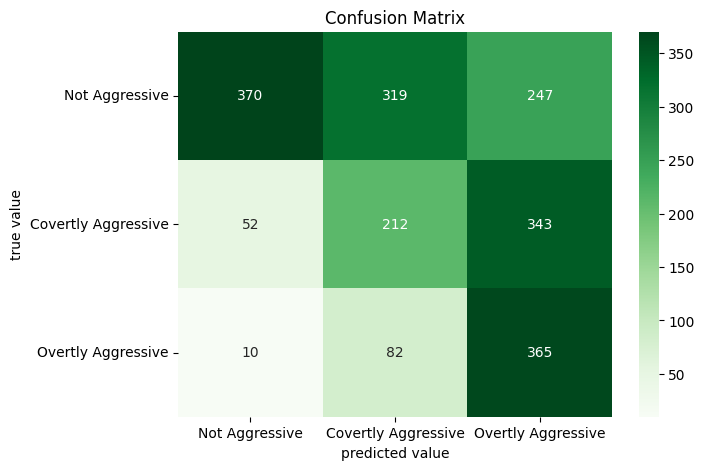

In [ ]:
model_copy=model
process_single_dataset(D2,model_copy, tokenizer, 'D2',generate_prompt_unified,few_shot_examples_D2)


Processing D3...


100%|██████████| 154/154 [13:11<00:00,  5.14s/it]


Results for D3:
Accuracy: 0.504

Classification Report:
                     precision    recall  f1-score   support

     Not Aggressive       0.83      0.38      0.52       544
Covertly Aggressive       0.42      0.54      0.47       410
 Overtly Aggressive       0.42      0.70      0.53       271

           accuracy                           0.50      1225
          macro avg       0.56      0.54      0.51      1225
       weighted avg       0.60      0.50      0.51      1225



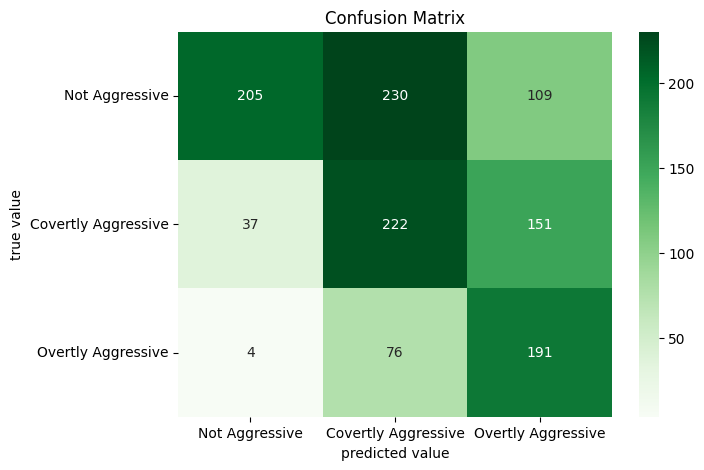

In [ ]:
model_copy=model
process_single_dataset(D3,model_copy, tokenizer, 'D3',generate_prompt_unified)


Processing D3...


100%|██████████| 154/154 [13:18<00:00,  5.18s/it]


Results for D3:
Accuracy: 0.587

Classification Report:
                     precision    recall  f1-score   support

     Not Aggressive       0.79      0.57      0.66       544
Covertly Aggressive       0.48      0.61      0.54       410
 Overtly Aggressive       0.51      0.58      0.54       271

           accuracy                           0.59      1225
          macro avg       0.59      0.59      0.58      1225
       weighted avg       0.62      0.59      0.59      1225



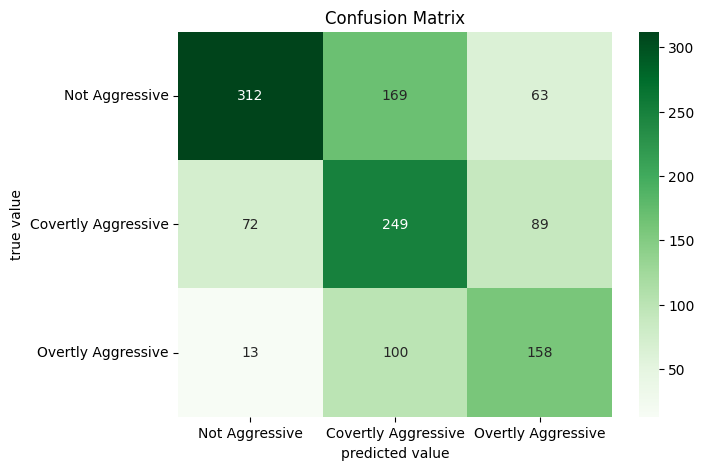

In [ ]:
few_shot_examples_D3=[
    # Category 0: Not Aggressive (3 examples)
    ("Nyc video sir", 0),
    ("Man you're too good.", 0),
    ("I don't know who is he but I like what he said", 0),

    # Category 1: Covertly Aggressive (3 examples)
    ("Hahahaha. Nice story", 1),
    ("What a joke no one believes such rubbish anymore", 1),
    ("I doubt this man's credibility..", 1),

    # Category 2: Overtly Aggressive (3 examples)
    ("It went against my will. Nathan coulter Nile. I will smash your head.", 2),
    ("Your language clearly shows the lower convert nair you are Nidhish nair !", 2),
    ("Such an ignorant racist comment. You have equated ignorance to Hinduism", 2)
]

model_copy=model
process_single_dataset(D3,model_copy, tokenizer, 'D3',generate_prompt_unified,few_shot_examples_D3)


Processing D4...


100%|██████████| 67/67 [05:48<00:00,  5.20s/it]


Results for D4:
Accuracy: 0.477

Classification Report:
                     precision    recall  f1-score   support

     Not Aggressive       0.98      0.43      0.60       411
Covertly Aggressive       0.15      0.38      0.22        60
 Overtly Aggressive       0.27      0.87      0.41        62

           accuracy                           0.48       533
          macro avg       0.47      0.56      0.41       533
       weighted avg       0.81      0.48      0.53       533



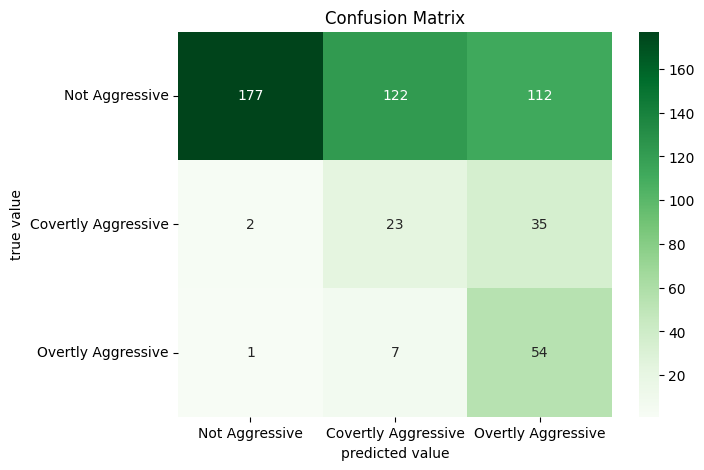

In [ ]:
model_copy=model
process_single_dataset(D4,model_copy, tokenizer, 'D4',generate_prompt_unified)


Processing D4...


100%|██████████| 67/67 [05:49<00:00,  5.22s/it]


Results for D4:
Accuracy: 0.615

Classification Report:
                     precision    recall  f1-score   support

     Not Aggressive       0.97      0.61      0.74       411
Covertly Aggressive       0.22      0.50      0.30        60
 Overtly Aggressive       0.36      0.79      0.49        62

           accuracy                           0.62       533
          macro avg       0.51      0.63      0.51       533
       weighted avg       0.81      0.62      0.67       533



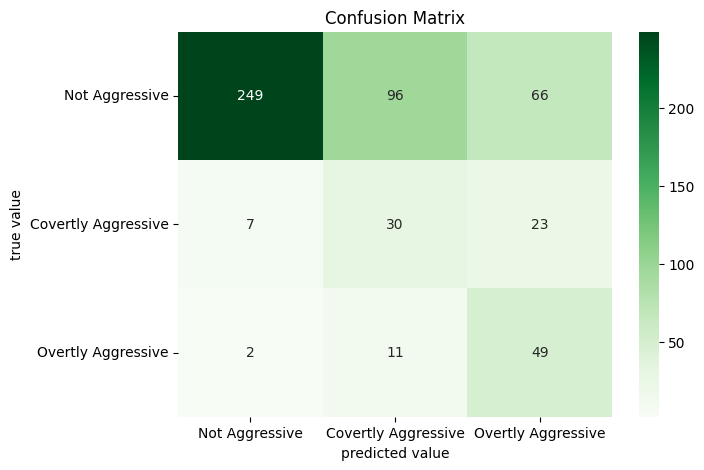

In [ ]:
few_shot_examples_D4=[
    # Category 0: Not Aggressive (3 examples)
    ("So True🤩", 0),
    ("Awesome explanation sir... Bigg fannn 😍😍😍😍", 0),
    ("Nice brother", 0),

    # Category 1: Covertly Aggressive (3 examples)
    ("Movie dekhne chatiho ya real life life Its just an entertainment Nothing else I guess its problem for those who Don't take it as e character", 1),
    ("I would like to do a correction 'fake feminist'", 1),
    ("Real men makes his purpose over pussy🙂😌", 1),

    # Category 2: Overtly Aggressive (3 examples)
    ("Feminism & liberalism @re cancer As I always say 😆😆😆👍🏻", 2),
    ("Fuck off libtars and chutiyanists.", 2),
    ("I would not even spit on you if you were on fire.", 2)
]
model_copy=model
process_single_dataset(D4, model_copy, tokenizer, 'D4',generate_prompt_unified,few_shot_examples_D4)


Processing D5...


100%|██████████| 188/188 [16:21<00:00,  5.22s/it]


Results for D5:
Accuracy: 0.503

Classification Report:
                     precision    recall  f1-score   support

     Not Aggressive       0.80      0.32      0.46       595
Covertly Aggressive       0.43      0.55      0.48       539
 Overtly Aggressive       0.47      0.73      0.57       366

           accuracy                           0.50      1500
          macro avg       0.57      0.53      0.50      1500
       weighted avg       0.59      0.50      0.49      1500



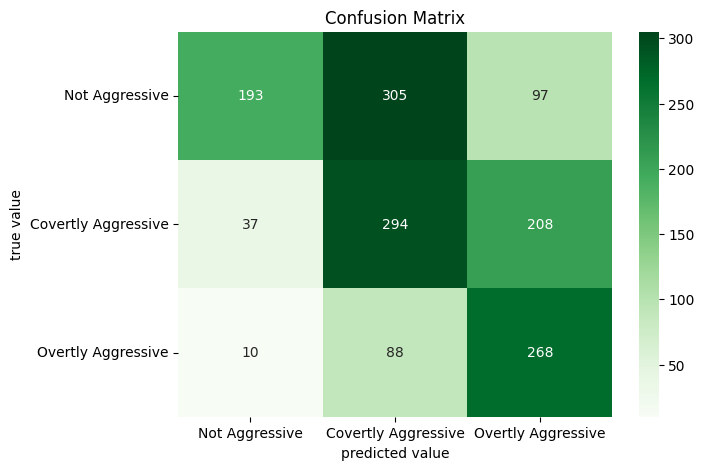

In [ ]:
model_copy=model
process_single_dataset(D5, model_copy, tokenizer, 'D5',generate_prompt_unified)


Processing D5...


100%|██████████| 188/188 [16:23<00:00,  5.23s/it]


Results for D5:
Accuracy: 0.550

Classification Report:
                     precision    recall  f1-score   support

     Not Aggressive       0.77      0.48      0.59       595
Covertly Aggressive       0.46      0.57      0.51       539
 Overtly Aggressive       0.51      0.63      0.56       366

           accuracy                           0.55      1500
          macro avg       0.58      0.56      0.55      1500
       weighted avg       0.59      0.55      0.55      1500



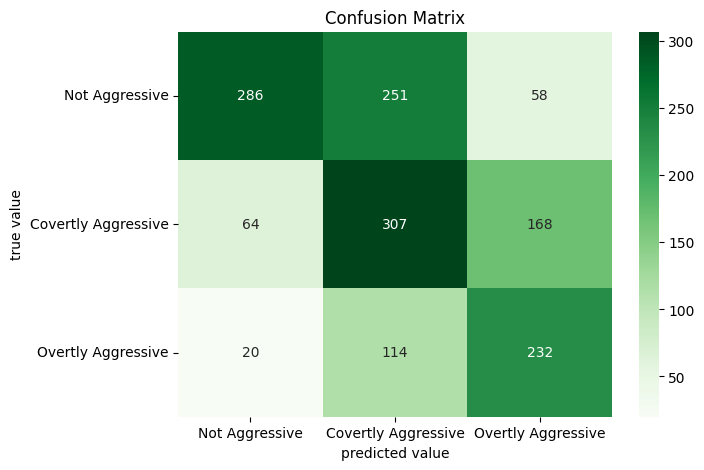

In [ ]:
few_shot_examples_D5=[
    # Category 0: Very clearly neutral/positive (stronger examples)
    ("what about TATA MOTORS .. can I buy at current levels?", 0),
    ("Well said 👍", 0),
    ("Thanks for ur valuable inputs", 0),

    # Category 1: Clear sarcasm but not ambiguous (clearer examples)
    ("Haha... He makes his face like an innocent baby.. But he is the most cunning..", 1),
    ("I don't believe him, waiting for 50days to prove him his sincerity.", 1),
    ("Just for own satisfaction, I know nothing will be changed", 1),

    # Category 2: Very explicitly aggressive (stronger examples)
    ("Fake", 2),
    ("Yeah..brainless bigots is wt u want!! So that nobdy challenges u!!", 2),
    ("These bigots are exploiting the religion, they only know violence and killing humans", 2)
]

model_copy=model
process_single_dataset(D5,model_copy, tokenizer, 'D5',generate_prompt_unified,few_shot_examples_D5)